$$\frac{d s(x)}{dx}=u(x)$$
$$s(0) = 0$$
$$s(x) =  \ ?$$

(100,) (10000, 100) (10000, 100)


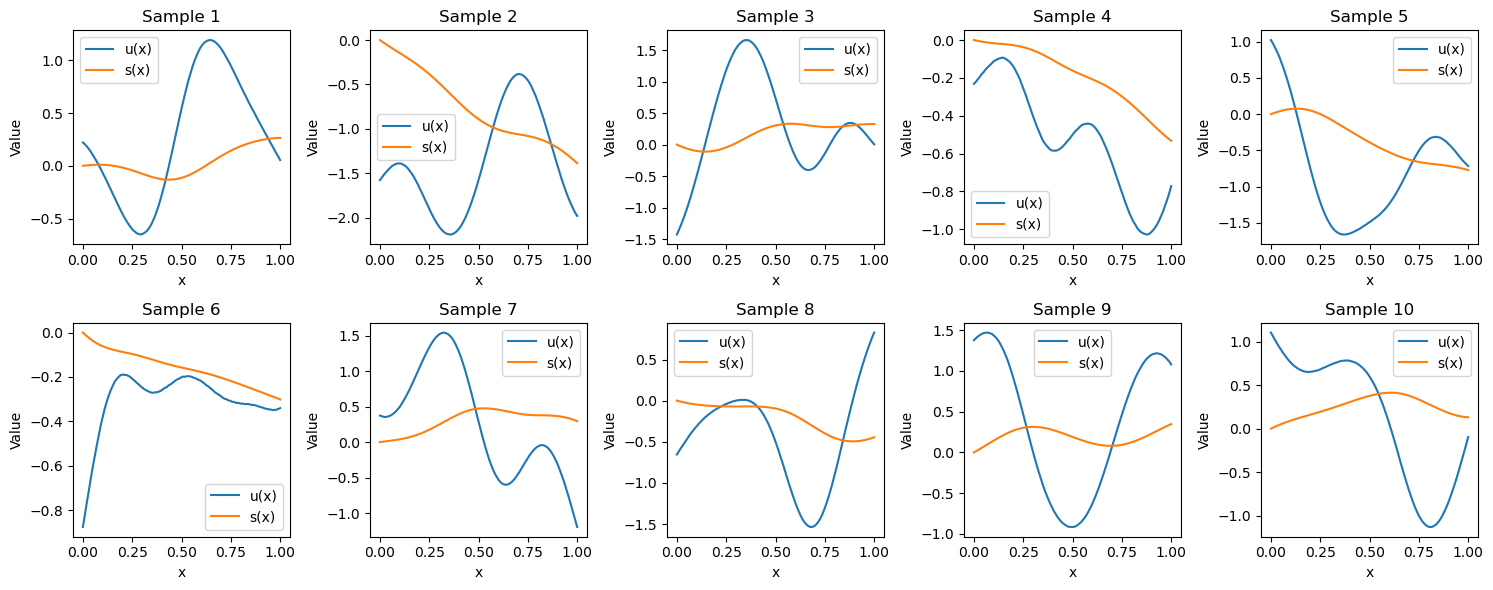

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import GPy
import os
import random 
os.environ['PYTHONHASHSEED'] = '0'
seed = 19
np.random.seed(seed=seed)
random.seed(seed)


# Define the kernels
kernels = {'rbf': GPy.kern.RBF, 'exp': GPy.kern.Exponential,
           'mat32': GPy.kern.Matern32, 'mat52': GPy.kern.Matern52}

# Define mean function
def mean(x):
    return np.zeros((x.shape[0], 1))

# Define function to generate samples and solve ODE
def generate_samples(kern, ellx, var, Lx, num_samples, nx):
    k = kern(1, lengthscale=ellx, variance=var)
    cellcenters = np.linspace(0, Lx, nx).reshape(-1, 1)
    m = mean(cellcenters)
    nugget = 1e-6
    Cov = k.K(cellcenters) + nugget * np.eye(cellcenters.shape[0])
    L = np.linalg.cholesky(Cov)

    u_samples = np.zeros((num_samples, nx))
    s_samples = np.zeros((num_samples, nx))

    for i in range(num_samples):
        z = np.random.randn(cellcenters.shape[0], 1)
        u_sample = m + np.dot(L, z)

        def ds_dx(x, s, u_interp):
            return u_interp(x)

        u_data = np.column_stack((cellcenters.ravel(), u_sample.ravel())) ## Assuming u_data is a numpy array with shape (N, 2) where columns represents (x, u(x))
        u_interp = interp1d(u_data[:, 0], u_data[:, 1], kind='linear', fill_value="extrapolate") # Interpolate u(x) data
        sol = solve_ivp(ds_dx, (0, Lx), [0], t_eval=cellcenters.ravel(), args=(u_interp,)) # Solve using solve_ivp
        
        u_samples[i] = u_sample.ravel()
        s_samples[i] = sol.y[0]

    return u_samples, s_samples

# Parameters
num_samples = 10000
k_ = 'rbf'
ellx = 0.2
var = 1.0
Lx = 1.0
nx = 100

# Get kernel
kern = kernels[k_]

cellcenters = np.linspace(0, Lx, nx)
# Generate samples and solve ODE
u_samples, s_samples = generate_samples(kern, ellx, var, Lx, num_samples, nx)

print(cellcenters.shape, u_samples.shape, s_samples.shape)

# Plot the results
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.plot(np.linspace(0, Lx, nx), u_samples[i], label='u(x)')
    plt.plot(np.linspace(0, Lx, nx), s_samples[i], label='s(x)')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Sample ' + str(i+1))
    plt.legend()

plt.tight_layout()
plt.show()

In [2]:
# Define the directory to save the files
data_dir = 'data'

# Create the directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Define file paths relative to the data directory
cellcenters_file = os.path.join(data_dir, 'cellcenters.npy')
u_samples_file = os.path.join(data_dir, 'u_samples.npy')
s_samples_file = os.path.join(data_dir, 's_samples.npy')

# Save cellcenters, usamples, and ssamples
np.save(cellcenters_file, cellcenters)
np.save(u_samples_file, u_samples)
np.save(s_samples_file, s_samples)

print(f"cellcenters saved to {cellcenters_file}")
print(f"u-samples saved to {u_samples_file}")
print(f"s-samples saved to {s_samples_file}")

cellcenters saved to data/cellcenters.npy
u-samples saved to data/u_samples.npy
s-samples saved to data/s_samples.npy
